In [1]:
import numpy as np
import matplotlib.pyplot as plt

from visualization_toolkit.plots.boxplot import boxplot
from visualization_toolkit.adapters.mse_noise import mse_noise_experiment

### Utils

In [2]:
def generate_clean_signals(
    n_signals: int,
    n_samples: int,
    fs: float = 1.0,
):
    t = np.arange(n_samples) / fs
    signals = []

    for _ in range(n_signals):
        x = np.sin(2 * np.pi * 0.05 * t) + 0.5 * np.sin(2 * np.pi * 0.12 * t)
        signals.append(x)

    return np.array(signals)


def add_noise(signal: np.ndarray, ratio: float) -> np.ndarray:
    """
    Adds noise with a specified ratio of signal to noise ratio (sigma_signal / sigma_noise).

    Parameters:
        signal: The original signal.
        ratio: The desired sigma_signal / sigma_noise ratio (for example, 10 = noise 10 times weaker).

    Returns:
        A noisy signal, noise.
    """
    sigma_signal = np.std(signal, ddof=1)
    sigma_noise = sigma_signal / ratio

    noise = np.random.normal(0, sigma_noise, size=signal.shape)

    return signal + noise, noise


def generate_noisy_dataset(
    clean_signals,
    noise_ratios,
):
    original = []
    noisy = []

    for ratio in noise_ratios:
        for signal in clean_signals:
            original.append(signal)
            noisy_signal, _ = add_noise(signal, ratio)
            noisy.append(noisy_signal)

    return np.array(original), np.array(noisy)


def moving_average(x, k):
    return np.convolve(x, np.ones(k) / k, mode="same")

### Usage example

In [3]:
noise_ratios = np.arange(0.1, 1.5, 0.5)
snr_array = 20 * np.log10(noise_ratios)
n_realizations = 20
n_samples = 512
print(noise_ratios, snr_array)

[0.1 0.6 1.1] [-20.          -4.43697499   0.8278537 ]


In [4]:
clean = generate_clean_signals(
    n_realizations,
    n_samples,
)

original_signals, noisy_signals = generate_noisy_dataset(
    clean,
    noise_ratios,
)

In [5]:
signals = {
    "N": noisy_signals,
    "MA-5": np.array([moving_average(x, 5) for x in noisy_signals]),
    "MA-2": np.array([moving_average(x, 2) for x in noisy_signals]),
}
mse_df = mse_noise_experiment(original_signals, signals, noise_ratios)
mse_df.head(5)

,snr,mse,label,run
0,-20.0,64.223171,N,0
1,-20.0,53.504414,N,1
2,-20.0,71.085939,N,2
3,-20.0,69.976326,N,3
4,-20.0,63.452058,N,4


In [21]:
styles = {
    "N": dict(
        patch_artist=True,
        flierprops={
            "markeredgecolor": "black",
            "markeredgewidth": 1.5,
            "markersize": 2,
        },
        whiskerprops={"color": "black", "linestyle": "--", "linewidth": 2},
        capprops={"color": "black", "linewidth": 2},
        boxprops={"facecolor": "white", "edgecolor": "black", "linewidth": 2},
        medianprops={"color": "black", "linewidth": 2.3},
    ),
    "MA-2": dict(
        patch_artist=True,
        flierprops={
            "markeredgecolor": "black",
            "markeredgewidth": 1.5,
            "markersize": 2,
        },
        whiskerprops={"color": "black", "linestyle": "--", "linewidth": 2},
        capprops={"color": "black", "linewidth": 2},
        boxprops={"facecolor": "lightgray", "edgecolor": "black", "linewidth": 2},
        medianprops={"color": "black", "linewidth": 2.3},
    ),
    "MA-5": dict(
        patch_artist=True,
            flierprops={"markeredgecolor": "black", "markeredgewidth": 1.5, "markersize": 2},
            whiskerprops={"color": "black", "linestyle": "--", "linewidth": 2},
            capprops={"color": "black", "linewidth": 2},
            boxprops={"facecolor": "white", "edgecolor": "black", "linewidth": 2, "hatch": "//"},
            medianprops={"color": "black", "linewidth": 2.3},
    ),
}

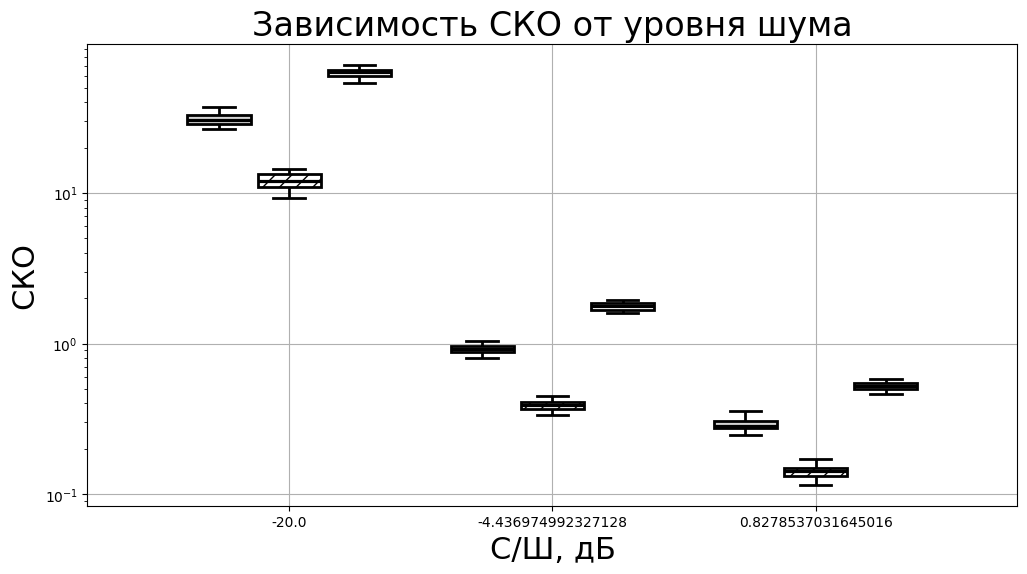

In [22]:
boxplot(mse_df, "snr", "mse", "label", broken=False, boxplot_kws=styles)
plt.show()

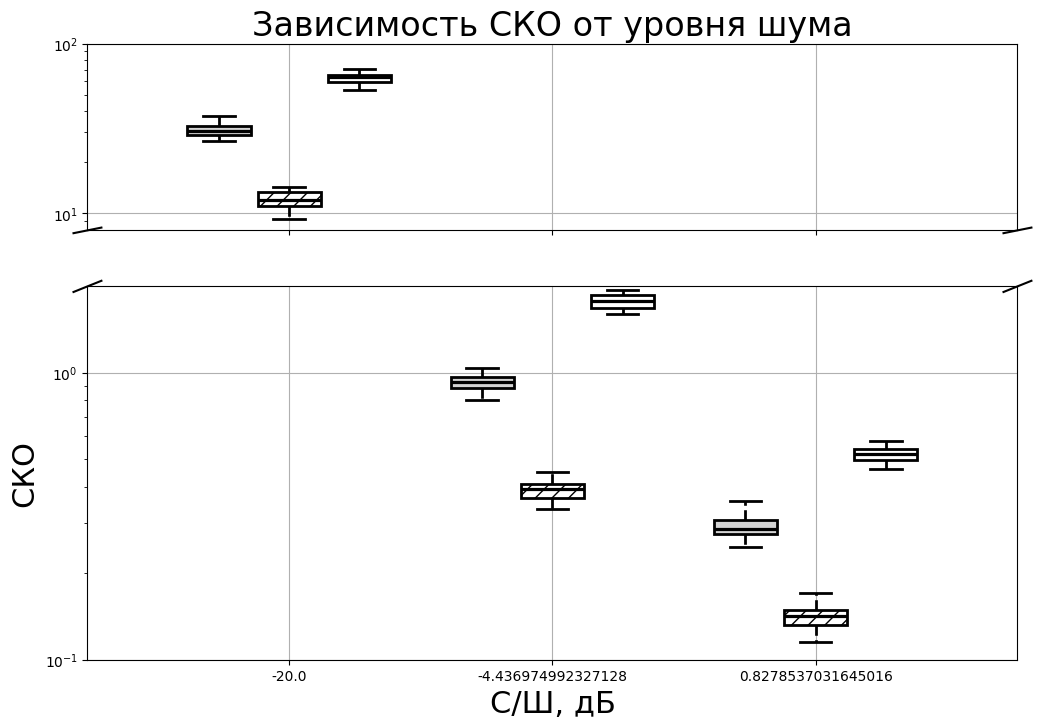

In [23]:
boxplot(mse_df, "snr", "mse", "label",
        broken=True,bottom_ylim= (10**(-1), 10**(0.3)), top_ylim=(10**(0.9), 10**(2)),
 boxplot_kws=styles)
plt.show()